# 4.1 Bayesian statistics and sampling schemes

In this notebook, we explore how to perform Bayesian inference from start to finish: How do we define generative and statistical models? How do we implement these models into an inference framework? How do we set priors and define likelihoods? And how do we interpret the framework output (the posterior)?

In [1]:
try:
    import pymc as pm # For MCMC
except:
    !pip install pymc
    import pymc as pm
try:
    import arviz as az # For MCMC package
except:
    !pip install arviz
    import arviz as az

**NB:** Above import pymc and arviz as a specific package for performing Bayesian sampling. Note that newer versions of pymc are not necessarily backwards compatible, which means that examples that you find in documentation for previous versions might no longer work without major modifications. Also, note that the older versions are generally more exhaustively documented.

In [2]:
try:
    import sobol_seq # For random grids
except:
    !pip install sobol_seq
    import sobol_seq
try:
    import pygtc # For plotting pair plots
except:
    !pip install pygtc
    import pygtc
try:
    import emcee # For MCMC
except:
    !pip install emcee
    import emcee

import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats # statistics packages
from multiprocessing import Pool # For parallelisation
from IPython.display import YouTubeVideo

The notebook has been developed to complement the lectures by [R. McElreath](https://github.com/rmcelreath/stat_rethinking_2023) in connection with training for postdoctoral fellows at I-X, Imperial College London. When writing the notebook, I put the focus on clarity, i.e., you are most certainly able to improve the performance of the code in some places... take that as an additional exercise.

# 1. Simulations

First, we define your model. Your model could be anything (linear model, ODEs, PDEs, agent-based models, etc.) and might or might not involve a large set of parameters and initial conditions. For simplicity, we consider a generic linear model here similar to the model chosen for an introduction to [PyMC](https://www.pymc.io/projects/docs/en/v3/pymc-examples/examples/getting_started.html).

In [3]:
RANDOM_SEED = 8000
np.random.seed(RANDOM_SEED)

# Size of dataset
size = 100

# Predictor variable
# Note that you don't always have these. Sometimes you have initial conditions instead, in which case
# you might need to let these be free parameters too if you don't know them
X1 = np.random.randn(size)
X2 = np.random.randn(size) * 0.2

def simulation(param):

    y = param[0]+param[1]*X1+param[2]*X2

    return y

To test your inference network, you must create synthetic data from your model. If your model is stochastic, i.e., it already incorporates a model of the noise, you are ready to go: Your model is already a generative model. If your model is deterministic, all you often need to do is add noise to the simulation, i.e. your generative model is also your statistical model. The task is then in a "hare and hound" exercise to see whether you can recover the ground truth, i.e., the true parameter values, by inference.

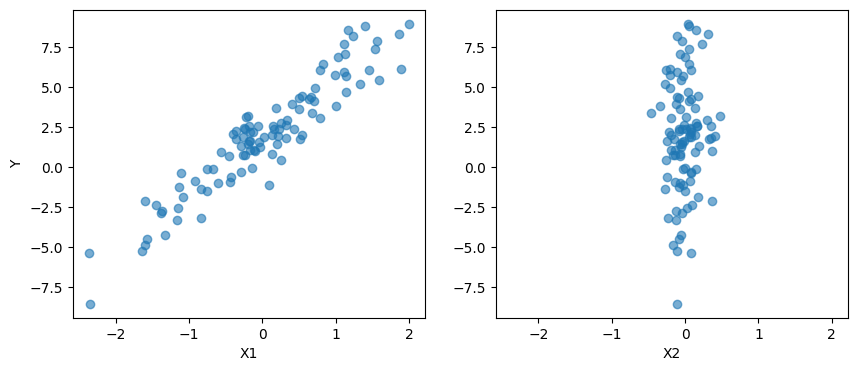

In [4]:
# True parameter values
sigma1 = 1
beta = [2, 3.5, 2.5]

# Simulate outcome variable
y_obs = simulation(beta) + np.random.randn(size) * sigma1
fig, axes = plt.subplots(1, 2, sharex=True, figsize=(10, 4))
axes[0].scatter(X1, y_obs, alpha=0.6)
axes[1].scatter(X2, y_obs, alpha=0.6)
axes[0].set_ylabel("Y")
axes[0].set_xlabel("X1")
axes[1].set_xlabel("X2");

**Exercise 1.1:** Create your own generative and statistical models for a simple case study in your field.

# 2. Grid search

Having created your model, we are ready to make the inference framework. One of the most straightforward approaches is to perform a grid search, i.e., to compute a large number of models spanning a region of the parameter space and compare each of them to the data individually. It's most accessible to picture this in 2D, so let's just vary two parameters. Moreover, let's compute the grid in a rudimentary fashion, assuming uniform priors for the parameters and using for loops.

In [5]:
# define grid. Note that there is not need for the grid to be regular (indeed that has some disadvantages).
# Random grid tend to cluster so, pseudo-ra
grid_points = 50
param1 = np.linspace(0, 6, grid_points)
param2 = np.linspace(0, 6, grid_points)
P1, P2 = np.meshgrid(param1,param2)

# define prior. Here, we will just put uniform priors.
# I.e. in this case, the prior is hiding in the choice that is the span of the parameter space (P1 and P2).
prior = 1

# compute likelihood at each point in the grid

L = []

for i, p1 in enumerate(param1):
    for j, p2 in enumerate(param2):
        # run simulation
        y_ij = simulation([2,p1,p2])
        # evaluate likelihood (consisten with assumptions in generative model. For simplicity, we just assume we know sigma.)
        likelihood_ij = np.sum(stats.norm.pdf(y_obs,loc=y_ij,scale=1))
        # store likelihood

        L.extend([likelihood_ij])

# compute product of likelihood and prior
unstd_posterior = np.asarray(L) * prior

# standardize the posterior, so it sums to 1
posterior = unstd_posterior / unstd_posterior.sum()

We can now plot the results. We indicate the ground truth here using a black cross.

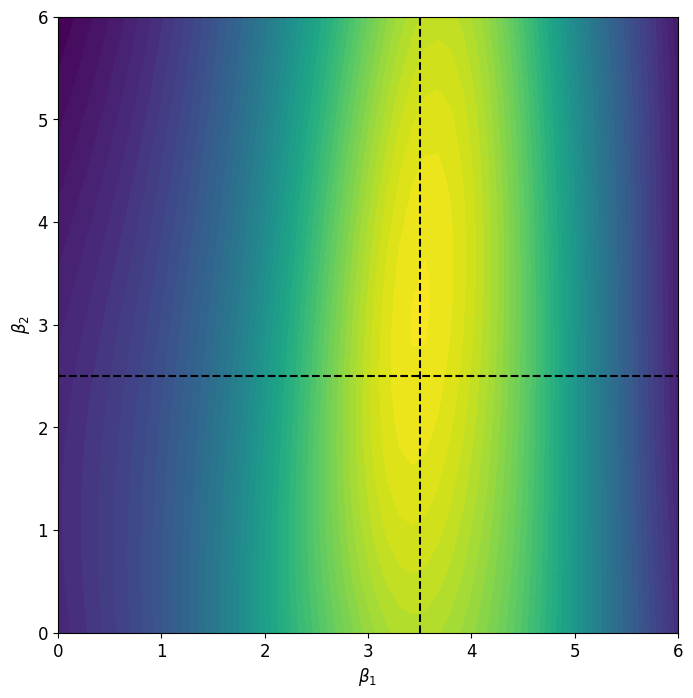

In [6]:
plt.figure(figsize=(8,8))
plt.tricontourf(P1.flatten(order="F"),P2.flatten(order="F"),posterior,50)
plt.axhline(y=beta[2],linestyle="--",color="k")
plt.axvline(x=beta[1],linestyle="--",color="k")
plt.xlabel(r"$\beta_1$",fontsize=12)
plt.ylabel(r"$\beta_2$",fontsize=12)
plt.xticks(size=12)
plt.yticks(size=12)
plt.show()

**Exercise 2.1:** As can be seen from the figure, our grid search does very well. However, grid searches have multiple problems. Which?

**Exercise 2.2:** Another useful test is the posterior predictive test, in which we ask what data we would observe given the posterior distribution of the parameters. Perform a posterior predictive test for the model presented in this section.

**Exercise 2.3:** The grid used above is regular. Is that a good choice? Why? Explore other choices.

**Exercise 2.4:** Perform a grid search for your own model  (cf. exercise 1.1).

# 3. ABC algorithms

Above, we define the likelihood directly using a normal distribution. However, for many real-world applications, the likelihood is intractable, i.e., we don't know what it is. To circumvent this issue, we use something called "surrogate likehoods", "likelihood-free inference" (LFI) or "approximate Bayesian inference" (ABC). You can use these terms interchangeably, and they basically all cover the same idea: We find a substitute that approximates the likelihood function. In ABC, we call this approximation the distance measure ($d$). A popular choice is the Euclidean distance or the Euclidean distance in units of the variance:

$$d^2=\sum_i \frac{(x_{\mathrm{mod},i}-x_{\mathrm{obs},i})^2}{\sigma_i^2}$$

where $x_{\mathrm{mod},i}$ denotes the predicted value, i.e., the model output, $x_{\mathrm{obs},i}$ is the observed value, and $\sigma_i$ is the corresponding observational error.

A simple form of ABC is rejection ABC. Again, we construct a grid. We then draw samples from this grid, only keeping those samples that lie within a certain distance ($d<\epsilon$) of the observations. However, this approach is statistically not sound since it only asymptotically approaches the correct posterior. Instead of introducing a cutoff ($\epsilon$), it is better to randomly draw from the grid accepting samples with a probability that depends on the distance $d$.

In [7]:
# Define grid. Note that there is no reason to make a regular grid. Indeed, that is often a terrible choice.
# A random grid similarly tends to produce "clumps", so a pseudo-random grid is a better choice.

grid_points_abc = 100000
interval = 6
sobols = interval*sobol_seq.i4_sobol_generate(2, grid_points_abc, 1)
P1 = sobols[:,0]
P2 = sobols[:,1]

D = []

for i in range(len(P1)):
    # run simulation
    y_ij = simulation([2,P1[i],P2[i]])
    # evaluate distance and store distance
    D.extend([np.sqrt(np.sum((y_ij-y_obs)**2/sigma1**2))])

P1_accept = []
P2_accept = []

for i, d in enumerate(np.asarray(D)/np.max(D)):
    # draw a random number
    dummy = np.random.uniform()
    if np.exp(-d**2/2) >= dummy:
        P1_accept.extend([P1[i]])
        P2_accept.extend([P2[i]])

Note, however, that we ended up with a bunch of samples this time, not with posteriors. So, we need other plotting tools. I really like the package pygtc:

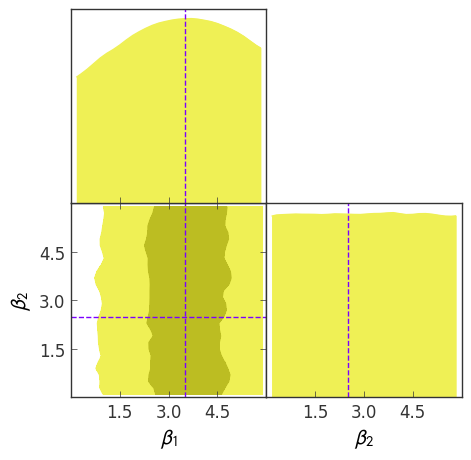

In [8]:
GTC = pygtc.plotGTC(chains=[np.column_stack((P1_accept,P2_accept))],
    figureSize='MNRAS_page',
    truths = beta[1:],
    paramNames=[r"$\beta_1$",r"$\beta_2$"],
    legendMarker='All',
#    do1dPlots=False,
    sigmaContourLevels=True,
    labelRotation=(0,0),
    truthColors=["#7b00ff"],
    truthLineStyles=["--"],
    customTickFont={'family':'Arial', 'size':12},
    colorsOrder=["yellows","purples"],
    customLabelFont={'family':'Arial', 'size':15}
    )

Overall, the results presented in the plot above are pretty consistent with the contour plot from the grid search, and that is not a coincidence. Indeed, if you look at a normal distribution, the logarithm of the probability density is given by $d^2$ (that is, up to a factor of 2 and ignoring a factor $1/\sqrt(2\pi\sigma_i)$ in front of the probability density, which we can ignore here because we normalise by the maximum posterior probability density. This factor is only ever important if you need to infer $\sigma_i$, cf. exercise 4.2.2). In other words, the used distance measure derives from the assumption that the noise is Gaussian. In the present case, this is a good (and indeed correct) assumption. For other data, this might be a simplifying assumption. But that's all there really is to ABC or LFI: Sometimes we have to make simplifying approximations, but subsequently, all our "golems" still work as before.

While on the topic, it is worth mentioning that the LFI/ABC literature, like all types of machine learning literature, underlies fashions that change with time and differ among different disciplines. For instance, somewhat confusingly, some like to call LFI simulation-based inference, while others acknowledge that they have constructed a simplified likelihood without branding the method as anything besides being Bayesian. When performing a literature search and attempting to go beyond your field, you should, therefore, keep in mind that you might miss out on interesting papers merely because of differences in jargon.

**Exercise 3.1**: Besides rejection ABC, there are other ABC algorithms such as Sequential Monte Carlo. What is that?

**Exercise 3.2**: The figure above is a pairplot. Explain what the different panels show.

# 4. MCMC

Grid searches and ABC approaches suffer from the curse of dimensionality, which merely means that you run in to problems when you have too many parameters. One way to address this issue is to draw the samples in such a way that the distribution of the accumulated samples in the parameter space are themselves an approximation to the posterior distribution. McElreath discusses these approaches in lecture 8 (see video below). Here, we will have a look at two packages: PyMC and Emcee.

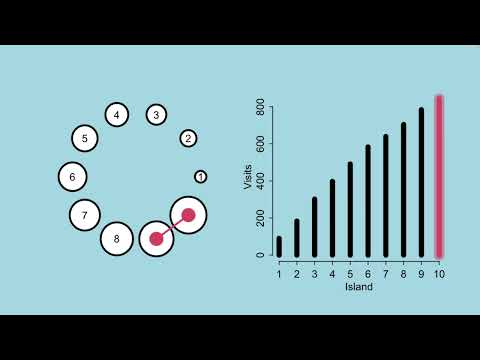

In [9]:
YouTubeVideo('rZk2FqX2XnY', width=500, height=300)

## 4.1 PyMC

First, we define the model. For more details, see the [homepage](https://www.pymc.io/projects/docs/en/v3/pymc-examples/examples/getting_started.html) of the package.

The basic logic is the same as above. First, we need to define our priors. Then, we need to define the likelihood. The likelihood relies on our model (simulations) and, as before, we can draw on the fact that we know that the noise is Gaussian (normal). In this case, let's also infer sigma.

In [10]:
basic_model = pm.Model()

with basic_model:

    # Priors for unknown model parameters
    param = pm.Normal("beta", mu=0, sigma=10, shape=3)
    sigma = pm.HalfNormal("sigma", sigma=1)

    # Expected value of outcome
    mu = simulation(param)

    # Likelihood (sampling distribution) of observations
    like = pm.Normal("like", mu=mu, sigma=sigma, observed=y_obs)

Note that the package includes different options to get parameter estimates. It can, e.g., deliver a maximum a posteriori (MAP) estimate, i.e., it can find the parameter set with the highest aposteriori value.

In [11]:
map_estimate = pm.find_MAP(model=basic_model)
map_estimate

Output()

{'beta': array([1.895054  , 3.56099641, 2.80373721]),
 'sigma_log__': array(0.0586192),
 'sigma': array(1.06037137)}

As you can see, the MAP estimate performs rather well. But we can do better than point estimates... we want the posterior distributions of the parameters. Again, we can choose differnt options. One is NUTS, a flexible MCMC algorithm. Running the sampler takes very few lines of code, and the arviz packages gives us the option to plot the results without much effort.

In [12]:
with basic_model:
    # instantiate sampler
    step = pm.Slice()

    # draw 5000 posterior samples
    trace = pm.sample(5000, step=step, return_inferencedata=True)

Output()

Output()

In [13]:
trace

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data

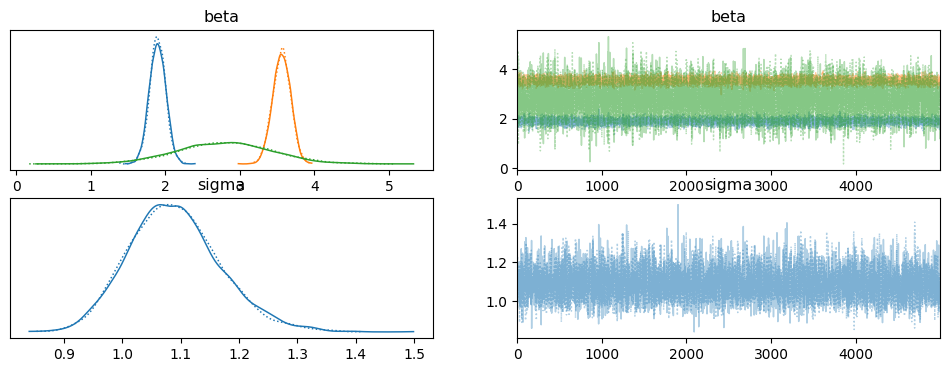

In [14]:
with basic_model:
    az.plot_trace(trace);

The left-hand panels show you the posterior distribution of the different parameters. The right-hand panels show you the Markov chains. The "fuzzy" nature of these seemingly otherwise flat lines tells you that PyMC is drawing samples in the vicinity of parameter set with the maximum posterior probability density. The chains seem to have converged.

In [15]:
with basic_model:
    display(az.summary(trace, round_to=2))

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta[0],1.90,0.11,1.69,2.10,0.00,0.0,8969.24,6794.16,1.0
beta[1],3.56,0.12,3.33,3.78,0.00,0.0,10447.31,7412.88,1.0
beta[2],2.79,0.63,1.63,3.98,0.01,0.0,10038.98,7372.04,1.0
sigma,1.09,0.08,0.95,1.24,0.00,0.0,8948.68,6457.95,1.0


**Exercise 4.1.1:** You can do better than simply looking at the trace plots when deciding whether the chains have converged. How would you do that? What measures exist for this purpose?

**Exercise 4.1.2:** You could do a posterior predictive test, i.e., you could check whether the predictions made by your model based on the evaluated posterior distributions match the ground truth. Perform such as test.

**Exercise 4.1.3:** After running the tests above and a posterior predictive test (cf. exercise 4.1.2), you might feel rather confident about the performance of your inference tool. However, before applying to real data what other sanity checks should you make?

## 4.2 Emcee

One of the advantages of the [emcee package](https://emcee.readthedocs.io/en/stable/) is that it's easier to peek under the hood. As before we start out by defining priors, likelihoods and posteriors.

When comparing models numerically, posterior _probabilities_ are in and of themselves somewhat impractical because they might easily become so small that you run into rounding errors. Under the hood, Bayesian sampling schemes hence draw on logarithmic probabilities. Futhermore, many algorithms don't look for maxima but for minima; so, rather than working with the priors and likelihoods, we need to define the negative log-priors and negative log-likelihood. For emcee, however, we are working with the log-priors and log-likelihood. Also, note that

$$log(ab)=log(a)+log(b),$$

i.e., we have to add the log-prior to the log-likelihood when applying Bayes' law. If we limit ourselves to uniform priors, these are 0 within the parameter regime of interest and negative infinity outside of this regime.

In [16]:
def get_prior(param,prior_lower_lim,prior_upper_lim):

    p = 0

    for pi in param:
        if pi < prior_lower_lim or pi > prior_upper_lim:
            p = -np.inf
            break

    return p

Luckily, we already know what the log-likelihood is: It's the negative of $d^2$ from Section 2.

In [17]:
def log_likelihood_func(param,y_obs,prior_lower_lim,prior_upper_lim):

    prior = get_prior(param,prior_lower_lim,prior_upper_lim)

    if prior != -np.inf:

        y_mod = simulation(param)

        L = - np.sum((y_mod-y_obs)**2/sigma1**2)

    else:

        L = -np.inf

    return L

Emcee is an ensemble sampler which means that there are several Markov chains working together to explore the parameter space. We call these chains walkers. First, we need to define the number of dimensions and the number of walkers.

In [18]:
ndim = len(beta)
nwalkers = 2*ndim

We then have to define the initial conditions for our parameters. In other words, what is our initial guess for the parameter values? This step was hidden in PyMC.

Now, what should we choose as our initial conditions? As a sanity check and a rule of thumb, it's a very good idea to make a "bad"/"broadly generic" guess. You want the sampler to find the correct values itself. The reason for this is that the Markov chains might very easily get stuck if something isn't set up correctly, i.e., the chains will not converge to the correct posterior distribution (see also exercise 4.2.1). So, you want to be sure that the sampler has actually explored the parameter space effeciently before trusting in the posterior distribution that you obtain.

In [19]:
# Initialisation
prior_lower_lim = 0
prior_upper_lim = 6

# You could settle for all types of initial distributions. Here, we just go for a uniform distribution
prior = np.random.uniform(low=prior_lower_lim, high=prior_upper_lim, size=(nwalkers,ndim))

In [20]:
num = 10000 # We compute 10,000 simulations per walker. So, with 6 walkers, we get 60,000 samples in total.

with Pool() as pool: # Let's parallelise the code
    # Define the sampler
    sampler = emcee.EnsembleSampler(nwalkers, ndim, log_likelihood_func, args=[y_obs,prior_lower_lim,prior_upper_lim], pool=pool)
    sampler.run_mcmc(prior, num)
    # extract the samples
    samples = sampler.get_chain(flat=True)
    # extract the log-likelihoods
    logl = sampler.get_log_prob(flat=True)
    act = sampler.get_autocorr_time()

Based on the output, we can make our own trace plots.

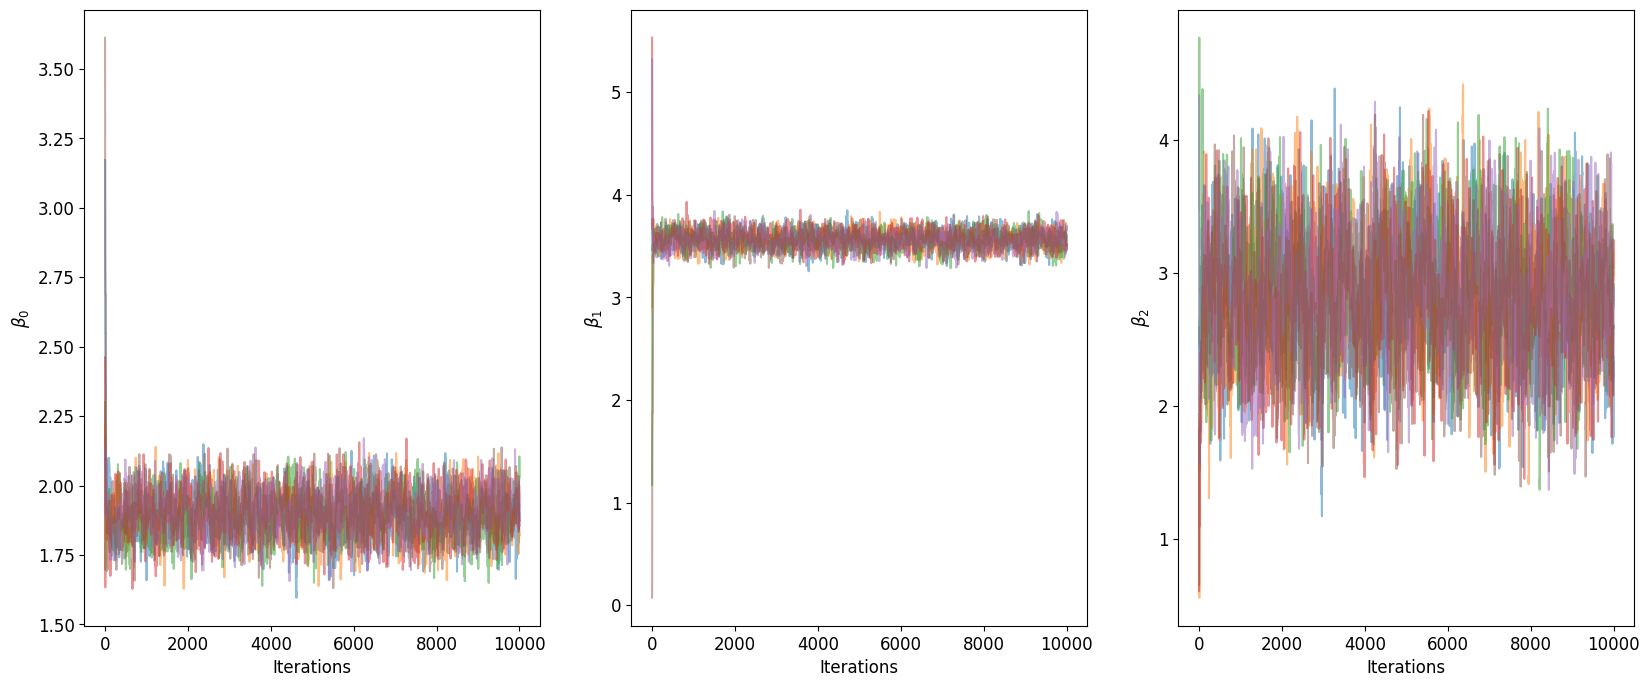

In [21]:
plt.figure(figsize=(20,8))
for i in range(ndim):
    plt.subplot(1,3,i+1)
    for j in range(nwalkers):
        plt.plot(samples[j::nwalkers,i],alpha=0.5)
    plt.xlabel("Iterations",fontsize=12)
    plt.ylabel(r"$\beta_"+str(i)+"$",fontsize=12)
    plt.xticks(size=12)
    plt.yticks(size=12)

**Exercise 4.2.1:** For our MCMC run, we have evaluated so-called autocorrelation times:

In [22]:
act

array([44.38474538, 42.54883296, 59.3511153 ])

Explain what these numbers mean.

**Exercise 4.2.2:** When inferring model parameters using emcee above, we did not constrain $\sigma$. How do we need to change the likelihood to do so? (Hint: Wait what... the logarithm of the likelihood is $d^2$... where did all the other factors go?)

**Exercise 4.2.3:** As you can see from the plots, the chains initially deviate strongly from the correct values. This behaviour is due to the sensitivity to the initial conditions and is connect to your answer to exercise 4.2.1 (How?). The first number of samples must hence be discarded. They are the so-called warm-up or burn-in. Exclude the samples in the burn-in before proceeding to 4.2.4.

**Exercise 4.2.4:** Construct a pairplot for the output of the MCMC (after excluding the burn-in).

**Exercise 4.2.5:** Implement other priors (e.g. normal priors).

**Exercise 4.2.6:** Change the initial conditions.